<a href="https://colab.research.google.com/github/skanderbenmansour/nlp_study_group/blob/master/NLP_SD_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Loading the data

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import json
import re
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [0]:
path = '/content/drive/My Drive/Health_and_Personal_Care_5.json'

In [4]:
data = []

with open(path,'r',encoding='utf8') as file:
  for line in tqdm(file):
    data.append(json.loads(line.strip()))
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [5]:
df = pd.DataFrame(data)
print(df.shape)
df.head()

(346355, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5.0,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4.0,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4.0,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5.0,Very nice and convenient.,1313452800,"08 16, 2011"


Breaking sentences into words

In [6]:
 regex_words = re.compile(r"[\w']+")
get_words = lambda text: [word for word in regex_words.findall(text.lower()) if word]
get_words('Hello how, are you ? Friend')

['hello', 'how', 'are', 'you', 'friend']

In [7]:
df['words'] = df['reviewText'].apply(get_words)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,words
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5.0,Handy little gadget,1294185600,"01 5, 2011","[this, is, a, great, little, gadget, to, have,..."
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012","[i, would, recommend, this, for, a, travel, ma..."
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4.0,Very good but not great,1275955200,"06 8, 2010","[what, i, liked, was, the, quality, of, the, l..."
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4.0,great addition to your purse,1202428800,"02 8, 2008","[love, the, great, point, light, pocket, magni..."
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5.0,Very nice and convenient.,1313452800,"08 16, 2011","[this, is, very, nice, you, pull, out, on, the..."


Removing outliers with too many words

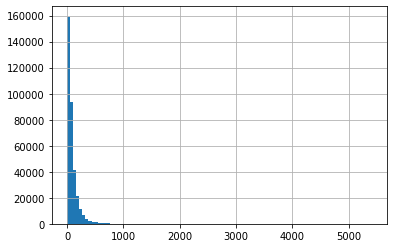

In [8]:
df['n_words'] = df['words'].apply(len)
df['n_words'].hist(bins = 100)

In [9]:
print(df.shape)
df = df[df['n_words'] < 300]
df.shape

(346355, 11)


(330893, 11)

Let's rebalance the 5 classes

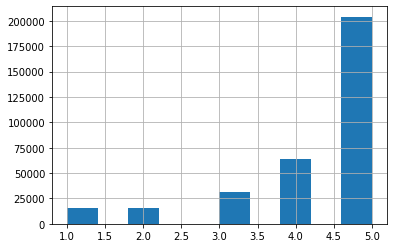

In [10]:
df['overall'].hist()

In [11]:
classes_freq = df['overall'].value_counts()
smallest_class = classes_freq.min()
display(classes_freq)

5.0    204131
4.0     63887
3.0     31242
1.0     15829
2.0     15804
Name: overall, dtype: int64

In [12]:
balanced_subset = df.groupby('overall').apply(lambda df: df.sample(smallest_class))
balanced_subset['overall'].value_counts()

5.0    15804
4.0    15804
3.0    15804
2.0    15804
1.0    15804
Name: overall, dtype: int64

Let's create a nice dataset with:
- array of words ids![alt text](https://)
- array of labels (here numerical from 0 to 4)

And also break into training and test

In [0]:
X = balanced_subset['words'].values
y = balanced_subset['overall'].values - 1

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
word_id = defaultdict(lambda: len(word_id))

In [0]:
for words in df['words']:
  for word in words:
    word_id[word]

In [0]:
n_words = len(word_id)
n_classes = 5

In [28]:
print(n_words)

126146


We're now ready for the training

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [20]:
torch.cuda.set_device(0)
torch.cuda.get_device_name()

'Tesla T4'

In [0]:

class BoWClassifier(nn.Module): 

    def __init__(self, num_labels, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)


    def forward(self, bow_vec):
        return F.log_softmax(self.linear(bow_vec), dim=1)


def make_bow_vector(sentence, word_to_ix):
    vec = torch.zeros(len(word_to_ix))
    for word in sentence:
        vec[word_to_ix[word]] += 1
    return vec.view(1, -1)


def make_target(label, label_to_ix):
    return torch.LongTensor([label]) # from 0 to 4


model = BoWClassifier(n_classes, n_words)


In [0]:
y

array([0., 0., 0., ..., 4., 4., 4.])

In [0]:
def eval_model(model,data,labels,sample=1.,show_f1=False,show_confusion=False):
  if sample != 1.:
    mask = np.random.random(size=len(data)) < sample
  data = data[mask]
  labels = labels[mask]
  log_probs = []
  with torch.no_grad():
    for instance in data: 
      bow_vec = make_bow_vector(instance, word_id)
      log_probs.append(model(bow_vec).numpy()[0])
  log_probs = np.vstack(log_probs)
  y_pred = log_probs.argmax(axis=1)
  confusion = confusion_matrix(labels,y_pred)
  f1 = f1_score(labels,y_pred, labels=range(5),average='micro')
  if show_f1:
    print('F1 score = %5.3f' % f1)
  if show_confusion:
    print(confusion)
  return log_probs,y_pred,confusion,f1

In [0]:



loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in tqdm(range(10)):
    for t,(instance, label) in tqdm(enumerate(zip(X_train,y_train))):
        model.zero_grad()

        bow_vec = make_bow_vector(instance, word_id)
        target = make_target(label, None)

        log_probs = model(bow_vec)

        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()

        if t % 10000 == 0:
          print(epoch,t)
          for word in ['good','bad','great','terrible']:
            print(word,next(model.parameters())[:, word_id[word]])
          print('Train')
          log_probs,y_pred,confusion,f1 = eval_model(model,X_train,y_train,sample=0.1,show_f1=True)
          print('Test')
          log_probs,y_pred,confusion,f1 = eval_model(model,X_test,y_test,sample=0.1,show_confusion=True,show_f1=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0
good tensor([ 0.0020, -0.0020,  0.0026,  0.0006, -0.0020], grad_fn=<SelectBackward>)
bad tensor([ 0.0796, -0.0201, -0.0181, -0.0190, -0.0168], grad_fn=<SelectBackward>)
great tensor([-0.0027, -0.0007, -0.0028,  0.0019,  0.0024], grad_fn=<SelectBackward>)
terrible tensor([-0.0024,  0.0015,  0.0019,  0.0026, -0.0015], grad_fn=<SelectBackward>)
Train
F! score = 0.201
Test
F! score = 0.202
[[531   0   0   0   0]
 [528   0   0   0   0]
 [538   0   0   0   0]
 [523   0   0   0   0]
 [508   0   0   0   0]]
10000
good tensor([-1.8418, -0.7903, -0.1380,  2.1401,  0.6313], grad_fn=<SelectBackward>)
bad tensor([ 1.5195,  0.7671, -0.7385, -0.8359, -0.7065], grad_fn=<SelectBackward>)
great tensor([-2.3764, -1.0663, -2.5859,  2.4705,  3.5562], grad_fn=<SelectBackward>)
terrible tensor([ 1.2371,  0.4869, -0.4775, -0.7008, -0.5436], grad_fn=<SelectBackward>)
Train
F! score = 0.393
Test
F! score = 0.365
[[260  86  43   9 113]
 [158  96  95  12 150]
 [ 73  96 131  27 177]
 [ 32  39 103  38 322]
 [ 24 

0
good tensor([-1.8368, -1.4258,  0.8613,  2.4411, -0.0386], grad_fn=<SelectBackward>)
bad tensor([ 3.2421, -1.3405, -0.1597, -0.6441, -1.0921], grad_fn=<SelectBackward>)
great tensor([-3.3195, -2.1474, -0.2616,  1.1491,  4.5775], grad_fn=<SelectBackward>)
terrible tensor([ 4.7388,  1.1864, -2.3937, -1.4045, -2.1250], grad_fn=<SelectBackward>)
Train
F! score = 0.432
Test
F! score = 0.418
[[355  44 103   7  53]
 [214  49 163  12  57]
 [ 97  36 305  20  93]
 [ 48  11 220  42 211]
 [ 30   9  82  29 355]]
10000
good tensor([-1.5857, -1.9062,  0.6907,  1.6992,  1.1033], grad_fn=<SelectBackward>)
bad tensor([ 2.0541, -0.3662, -0.3172,  0.0950, -1.4600], grad_fn=<SelectBackward>)
great tensor([-3.2317, -0.9514, -1.5390,  1.9087,  3.8116], grad_fn=<SelectBackward>)
terrible tensor([ 4.6293,  1.7711, -2.7798, -0.9900, -2.6286], grad_fn=<SelectBackward>)
Train
F! score = 0.445
Test
F! score = 0.415
[[406  28  40  18  36]
 [307  36 111  62  45]
 [165  21 172 100  57]
 [ 84   7 118 173 134]
 [ 75 

0
good tensor([-2.0060, -1.4504, -0.2451,  2.7154,  0.9874], grad_fn=<SelectBackward>)
bad tensor([ 1.9108, -0.9345,  0.2984, -0.3484, -0.9205], grad_fn=<SelectBackward>)
great tensor([-3.0715, -2.6765, -0.3962,  0.9250,  5.2172], grad_fn=<SelectBackward>)
terrible tensor([ 6.1561,  1.8266, -2.9880, -1.7927, -3.2000], grad_fn=<SelectBackward>)
Train
F! score = 0.420
Test
F! score = 0.378
[[311  82  15  11 105]
 [161 101  27  28 171]
 [105  84  62  47 247]
 [ 35  29  28  68 389]
 [ 31   9  14  21 455]]
10000
good tensor([-0.7897, -2.4098,  0.0068,  2.4116,  0.7825], grad_fn=<SelectBackward>)
bad tensor([ 1.4409, -0.3164, -1.2394,  0.9872, -0.8665], grad_fn=<SelectBackward>)
great tensor([-3.2318, -1.0343, -1.0307,  1.5577,  3.7372], grad_fn=<SelectBackward>)
terrible tensor([ 5.8046,  2.2955, -3.2446, -1.2977, -3.5556], grad_fn=<SelectBackward>)
Train
F! score = 0.451
Test
F! score = 0.404
[[203 128 147   5  41]
 [ 95 104 263   2  36]
 [ 34  63 386  10  54]
 [ 16  31 287  24 145]
 [ 19 

0
good tensor([-1.7317, -1.5509,  0.0550,  2.1885,  1.0403], grad_fn=<SelectBackward>)
bad tensor([ 1.9886, -1.1717,  0.2320, -0.9966, -0.0465], grad_fn=<SelectBackward>)
great tensor([-3.1990, -3.5325,  0.3783,  1.6333,  4.7180], grad_fn=<SelectBackward>)
terrible tensor([ 5.6713,  3.5040, -3.4604, -1.6899, -4.0229], grad_fn=<SelectBackward>)
Train
F! score = 0.455
Test
F! score = 0.391
[[289 122  19   5 100]
 [148 154  53  18 145]
 [ 77 113  93  44 210]
 [ 23  45  52  62 333]
 [ 20  16  20  26 422]]


In [0]:

EMBEDDING_DIM = 10



class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [30]:
CONTEXT_SIZE = 5

dataset = []
for words in tqdm(balanced_subset['words']):
  if len(words) >= CONTEXT_SIZE + 1:
    for i in range(len(words)-1-CONTEXT_SIZE):
      pred = words[i:i+CONTEXT_SIZE]
      dep = words[i+CONTEXT_SIZE]
      dataset.append((pred,dep))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [31]:
dataset[:10]

[(['i', 'normally', 'do', 'not', 'have'], 'sensitive'),
 (['normally', 'do', 'not', 'have', 'sensitive'], 'skin'),
 (['do', 'not', 'have', 'sensitive', 'skin'], 'this'),
 (['not', 'have', 'sensitive', 'skin', 'this'], 'is'),
 (['have', 'sensitive', 'skin', 'this', 'is'], 'the'),
 (['sensitive', 'skin', 'this', 'is', 'the'], 'first'),
 (['skin', 'this', 'is', 'the', 'first'], 'time'),
 (['this', 'is', 'the', 'first', 'time'], 'in'),
 (['is', 'the', 'first', 'time', 'in'], 'my'),
 (['the', 'first', 'time', 'in', 'my'], 'life')]

In [0]:
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(word_id), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

running_loss = 0
alpha = 0.999

for epoch in range(10):
    total_loss = 0
    for t,(context, target) in enumerate(tqdm(dataset)):

        
        context_idxs = torch.tensor([word_id[w] for w in context], dtype=torch.long)

        model.zero_grad()


        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_id[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        running_loss = alpha*running_loss + (1-alpha)*loss.item()

        if t % 100 == 0:
          print(epoch,t,running_loss)
        
        
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


0 0 0.0119798402786255
0 100 1.1302089241118116
0 200 2.1405301416210114
0 300 3.0588386141247077
0 400 3.8858924716032934
0 500 4.6334281006981675


In [0]:
 bif t % 10000 == 0:
          print(epoch,t)
          for word in ['good','bad','great','terrible']:
            print(word,next(model.parameters())[:, word_id[word]])
          print('Train')
          log_probs,y_pred,confusion,f1 = eval_model(model,X_train,y_train,sample=0.1,show_f1=True)
          print('Test')
          log_probs,y_pred,confusion,f1 = eval_model(model,X_test,y_test,sample=0.1,show_confusion=True,show_f1=True)